In [1]:
from pathlib import Path

import accelerate
import datasets
from datasets import Dataset
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from transformers import PreTrainedTokenizerFast
from transformers import BertConfig, BertForMaskedLM


from genslm.utils import read_fasta, Sequence

In [2]:
# Get tokenizer

special_tokens = {
    "unk_token": "[UNK]",
    "cls_token": "[CLS]",
    "sep_token": "[SEP]",
    "pad_token": "[PAD]",
    "mask_token": "[MASK]",
    "bos_token": "[BOS]",
    "eos_token": "[EOS]",
}

tokenizer = PreTrainedTokenizerFast.from_pretrained("mdh-codon-bpe")
tokenizer.add_special_tokens(special_tokens)
None

In [25]:
# Sequence pre-processing helpers

# Assign a unique character to each codon so that we can use it as an
# input token to a BPE tokenizer. This implements a codon-pair encoding.
CODON_CHAR = {
    "TCG": "A",
    "GCA": "B",
    "CTT": "C",
    "ATT": "D",
    "TTA": "E",
    "GGG": "F",
    "CGT": "G",
    "TAA": "H",
    "AAA": "I",
    "CTC": "J",
    "AGT": "K",
    "CCA": "L",
    "TGT": "M",
    "GCC": "N",
    "GTT": "O",
    "ATA": "P",
    "TAC": "Q",
    "TTT": "R",
    "TGC": "S",
    "CAC": "T",
    "ACG": "U",
    "CCC": "V",
    "ATC": "W",
    "CAT": "X",
    "AGA": "Y",
    "GAG": "Z",
    "GTG": "a",
    "GGT": "b",
    "GCT": "c",
    "TTC": "d",
    "AAC": "e",
    "TAT": "f",
    "GTA": "g",
    "CCG": "h",
    "ACA": "i",
    "CGA": "j",
    "TAG": "k",
    "CTG": "l",
    "GGA": "m",
    "ATG": "n",
    "TCT": "o",
    "CGG": "p",
    "GAT": "q",
    "ACC": "r",
    "GAC": "s",
    "GTC": "t",
    "TGG": "u",
    "CCT": "v",
    "GAA": "w",
    "TCA": "x",
    "CAA": "y",
    "AAT": "z",
    "ACT": "0",
    "GCG": "1",
    "GGC": "2",
    "CTA": "3",
    "AAG": "4",
    "AGG": "5",
    "CAG": "6",
    "AGC": "7",
    "CGC": "8",
    "TTG": "9",
    "TCC": "!",
    "TGA": "@",
}

CHAR_CODON = {v: k for k, v in CODON_CHAR.items()}


def group_and_contextualize(seq: str, k: int = 3):
    grouped_codons = " ".join(seq[i : i + k] for i in range(0, len(seq), k)).upper()
    # Removes all modulo 3 chars
    return "".join(CODON_CHAR.get(codon, "") for codon in grouped_codons.split())


def decode_grouped_context(seq: str, sep: str = " "):
    return sep.join(CHAR_CODON[elem] for elem in seq)

In [7]:
sequence_file = Path(
    "/lambda_stor/homes/khippe/genslm_foundation/genome_data/mdh_sc23/fasta/mdh_natural_sequences.ffn"
)
sequences = read_fasta(sequence_file)


dataset_seqs = [group_and_contextualize(seq.sequence) for seq in sequences]
tokenized_seqs = tokenizer(
    dataset_seqs,
    max_length=1024,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)


data = {
    "input_ids": tokenized_seqs.input_ids.tolist(),
    "attention_mask": tokenized_seqs.attention_mask.tolist(),
}

dataset = Dataset.from_dict(data)
print(dataset)

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 36631
})


In [66]:
# See average length

tokenized_lens = [sum(elem["attention_mask"]) for elem in dataset]
pd.DataFrame(tokenized_lens).describe()

,0
count,36631.000000
mean,123.121373
std,24.428944
min,38.000000
25%,110.000000
50%,125.000000
75%,138.000000
max,187.000000


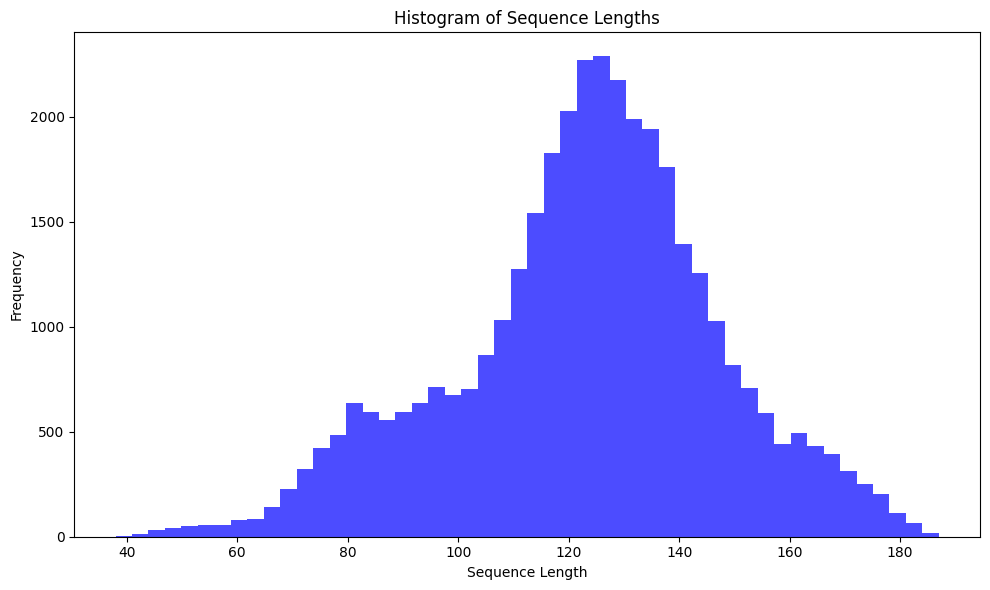

In [9]:
import matplotlib.pyplot as plt

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plotting the histogram
plt.hist(tokenized_lens, bins=50, color="blue", alpha=0.7)

# Setting title and labels
plt.title("Histogram of Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")

# Display the plot
plt.tight_layout()
plt.show()

                  0
count  50257.000000
mean       4.031419
std        1.958933
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max       44.000000


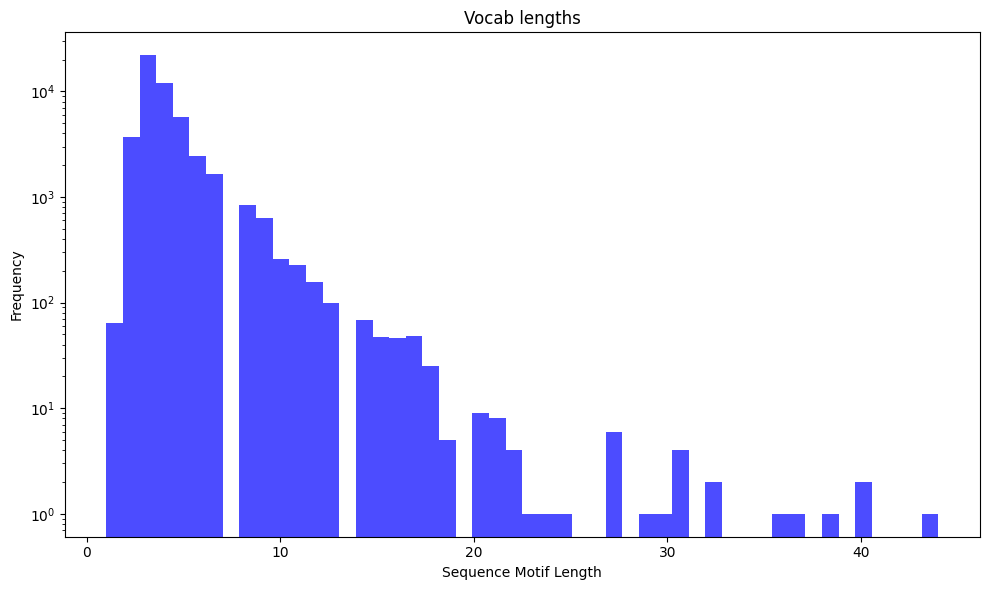

In [19]:
# plot of vocab sequence lengths
vocab_lens = [len(elem) for elem in tokenizer.get_vocab().keys()]

import pandas as pd

df = pd.DataFrame(vocab_lens)
print(df.describe())

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plotting the histogram
plt.hist(vocab_lens, bins=50, color="blue", alpha=0.7)
plt.yscale("log")

# Setting title and labels
plt.title("Vocab lengths")
plt.xlabel("Sequence Motif Length")
plt.ylabel("Frequency")

# Display the plot
plt.tight_layout()
plt.show()

In [26]:
import numpy as np

vocab_strs = list(tokenizer.get_vocab().keys())
max_idx = np.argmax(vocab_lens)
vocab_strs[max_idx], decode_grouped_context(vocab_strs[max_idx])

('nr80Vaetrtr21N26WbQNlJd8WN!26lJ21saht4l8JlZW',
 'ATG ACC CGC ACT CCC GTG AAC GTC ACC GTC ACC GGC GCG GCC GGC CAG ATC GGT TAC GCC CTG CTC TTC CGC ATC GCC TCC GGC CAG CTG CTC GGC GCG GAC GTG CCG GTC AAG CTG CGC CTC CTG GAG ATC')

In [31]:
long_vocab_id = tokenizer.encode("nr80Vaetrtr21N26WbQNlJd8WN!26lJ21saht4l8JlZW")[1]

count = 0
for elem in tokenized_seqs.input_ids:
    if long_vocab_id in elem:
        count += 1

print(count)

19


In [34]:
tokenizer.decode([max_idx])

'Z2I'

In [56]:
from collections import defaultdict
from tqdm import tqdm

counts = defaultdict(int)
vocab = tokenizer.get_vocab()
for elem in tqdm(tokenized_seqs.input_ids):
    for id in elem[1:-1]:
        id_str = tokenizer.decode([id])
        counts[id_str] += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36631/36631 [04:48<00:00, 126.97it/s]


                  0
count  50247.000000
mean      88.299739
std      324.389515
min        1.000000
25%       16.000000
50%       24.000000
75%       48.000000
max     7593.000000


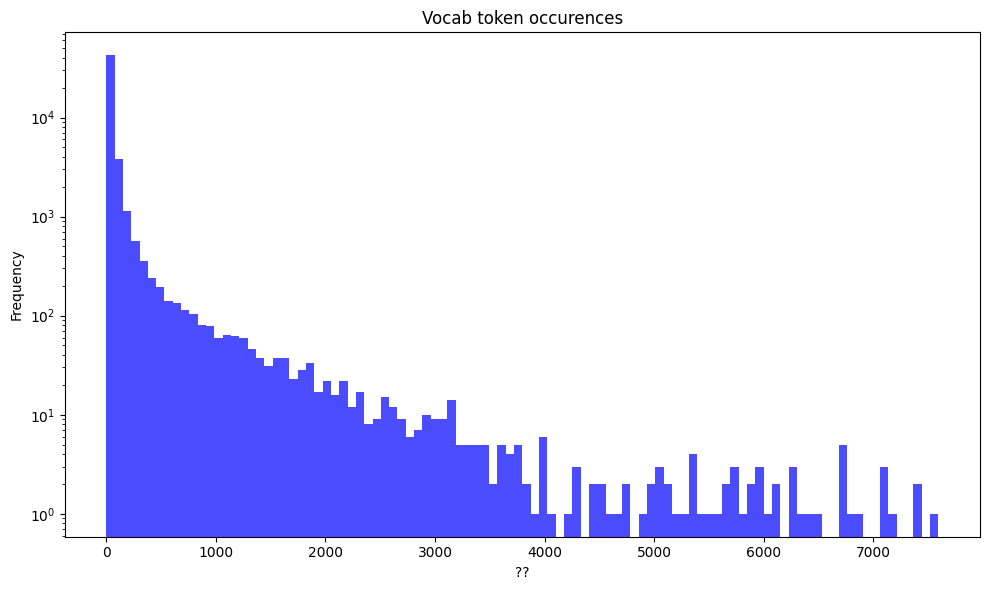

In [58]:
# plot of vocab sequence lengths

# remove special tokens from being counted
for val in special_tokens.values():
    if val in counts:
        del counts[val]

vocab_occs = list(counts.values())
vocab_occs_filtered = [v for v in vocab_occs if v < 10000]

import pandas as pd

df = pd.DataFrame(vocab_occs_filtered)
print(df.describe())

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plotting the histogram
plt.hist(vocab_occs_filtered, bins=100, color="blue", alpha=0.7)
plt.yscale("log")

# Setting title and labels
plt.title("Vocab token occurences")
plt.xlabel("??")
plt.ylabel("Frequency")

# Display the plot
plt.tight_layout()
plt.show()

In [63]:
# look at most common token

common_token_idx = np.argmax(vocab_occs)
print()
common_token = list(counts.keys())[common_token_idx]
f"{vocab_occs[common_token_idx]} occurences", common_token, decode_grouped_context(
    common_token
)

('7593 occurences', 'K', 'AGT')